# "Implémentez un modèle de scoring"
_Cleaning the data | Exploratory Data Analysis_


References used for this notebook:

- "https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda"
- 

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Mounting my Drive if on Colab

In [1]:
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Installations and importations required in the virtual environment.

In [2]:
import os
os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET7/NOTEBOOKS')
# !pip install -r requirements.txt

In [3]:
from P7_functions import *

Installations (creating the requirements file)

In [4]:
# !pip freeze > requirements_merging.txt

Importation of modules and packages. 

In [5]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Setting pandas display options.

In [6]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

## 1 Importation

In [7]:
# ### Pickling the aggregated dataset

# import dill as pickle

# with open('dict_df_agg.pkl', 'wb') as file:
#     pickle.dump(dict_df, file)

In [8]:
### Importation

import dill as pickle

with open('dict_df_agg.pkl', 'rb') as file:
    dict_df = pickle.load(file)

## 4 Exploratory analysis

### 4.0 Global shape description

#### Target identification

In [9]:
dict_df['app_train'].columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'PA_DAYS_TOT_DURATION__sum', 'PA_DAYS_TOT_DURATION__amp', 'PA_DAYS_TOT_DURATION__mean',
       'PA_DAYS_TOT_DURATION__max', 'PA_DAYS_PROLONG_PCT__mean', 'PA_DAYS_PROLONG_PCT__max',
       'PA_OUTSTANDING_LOAN__sum', 'PA_OUTSTANDING_LOAN__size', 'PA_AMT_DIFF_PCT__mean',
       'PA_AMT_DIFF_PCT__max'],
      dtype='object', length=211)

In [10]:
# set SK_ID_CURR as the index (and thus exclude of the analysis)

dict_df['app_train'] = dict_df['app_train'].set_index('SK_ID_CURR')

In [11]:
# number of values with each outcome (0->repaid loan ; 1->not repaid loan)

dict_df['app_train']['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [12]:
# pct of values with each outcome (0->repaid loan ; 1->not repaid loan)

dict_df['app_train']['TARGET'].value_counts(normalize=True)

0   0.92
1   0.08
Name: TARGET, dtype: float64

In [13]:
# check if missing values of the target

dict_df['app_train']['TARGET'].isna().sum()

0

Name of the target feature in the dataframe : 'TARGET'

It's a binary column and it has no missing values.

The target feature has imbalanced distribution (approx 8% positive values)

#### Number of lines and columns

In [14]:
# get (nb of lines, nb of columns)

dict_df['app_train'].shape

(307511, 210)

#### Types of the features

In [15]:
# features types

dict_df['app_train'].dtypes.value_counts()

float64    168
int64       26
object      16
dtype: int64

In [16]:
# getting categorical and quantitative columns

cat_cols = dict_df['app_train'].select_dtypes(exclude=[np.number]).columns
quant_cols = dict_df['app_train'].select_dtypes(include=[np.number]).columns

bin_cols = dict_df['app_train'].columns[dict_df['app_train'].nunique()==2]
int_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
f64_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()<100]
f64_high_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

In [17]:
# categorical vs. numerical

len(cat_cols), len(quant_cols)

(16, 194)

In [18]:
# binary, integer, floats

len(bin_cols), len(int_cols), len(f64_cols)

(30, 7, 162)

In [19]:
# distinction based on number of unique values among the floats

len(f64_low_nunique), len(f64_high_nunique)

(63, 99)

In [20]:
len(low_nunique)

116

Some of the integer columns with very few unique values are already encoded categorical columns.

Some float columns also have very few unique values and could be interpreted as categorical columns.

#### Exploring missing values

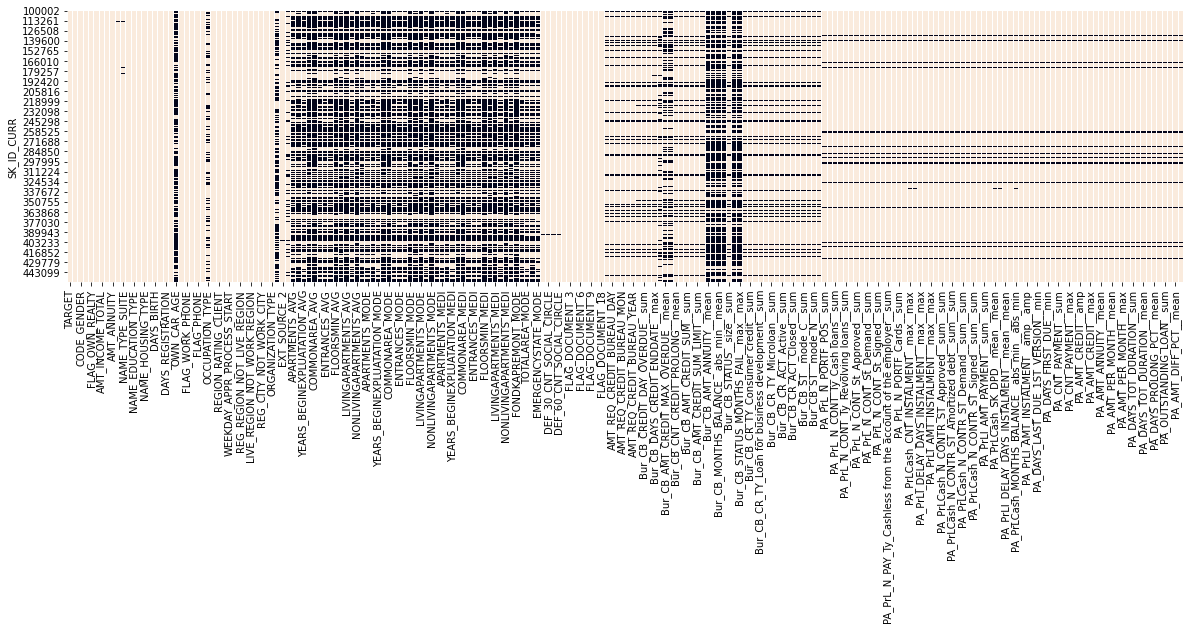

In [21]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(dict_df['app_train'].notna(), cbar=False)

In [22]:
# # fill all values coming from a sum (aggregation)

# cols_sum = dict_df['app_train'].columns[dict_df['app_train']\
#                                         .columns.str.contains('__sum')]
# dict_df['app_train'][cols_sum] = dict_df['app_train'][cols_sum].fillna(0)

In [23]:
# Have a overview of the missing values

df_miss = missing_data(dict_df['app_train'])

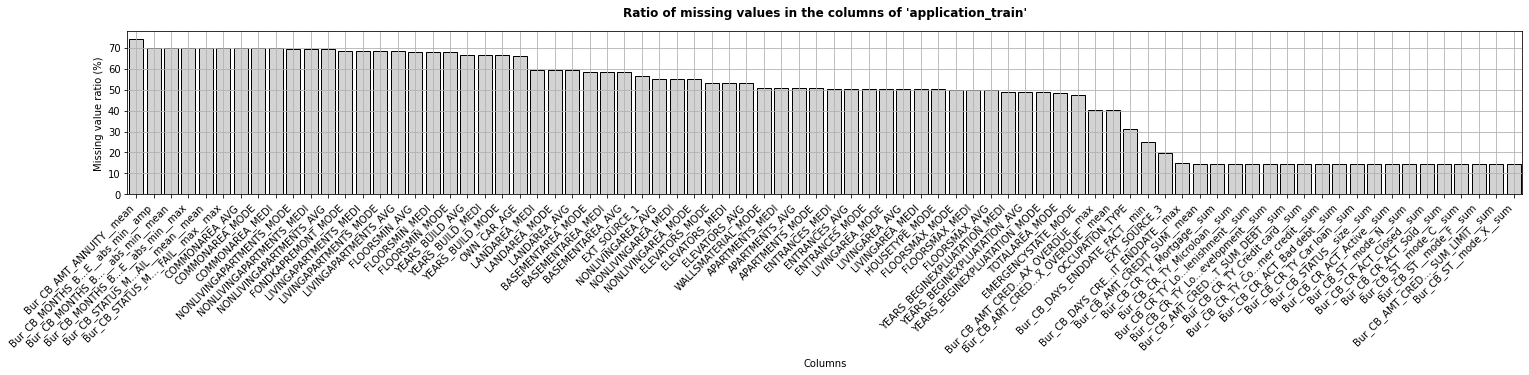

In [24]:
plot_simple_barplot(x = df_miss.index[:80],
                    y = df_miss['Percent'].iloc[:80],
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(25,3), color='lightgrey')

A lot of missing values.

#### Features elimination based on missing values

In [25]:
# display the number and the name of the columns to delete because exceeding 50% missing values

miss_more_45_cols = dict_df['app_train'][df_miss[df_miss['Percent']>45].index].columns
print(len(miss_more_45_cols), list(miss_more_45_cols))

55 ['Bur_CB_AMT_ANNUITY__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__amp', 'Bur_CB_MONTHS_BALANCE__abs_min__mean', 'Bur_CB_MONTHS_BALANCE__abs_min__max', 'Bur_CB_STATUS_MONTHS_FAIL__mean__mean', 'Bur_CB_STATUS_MONTHS_FAIL__max__max', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG', 'BASEMENTAREA_MODE', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'EXT_SOURCE_1', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'ELEVATORS_MODE', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_MODE', 'LIVINGAREA_

In [26]:
# keep only features with more than 50% notna values

dict_df['app_train'] = dict_df['app_train'].drop(columns=miss_more_45_cols)

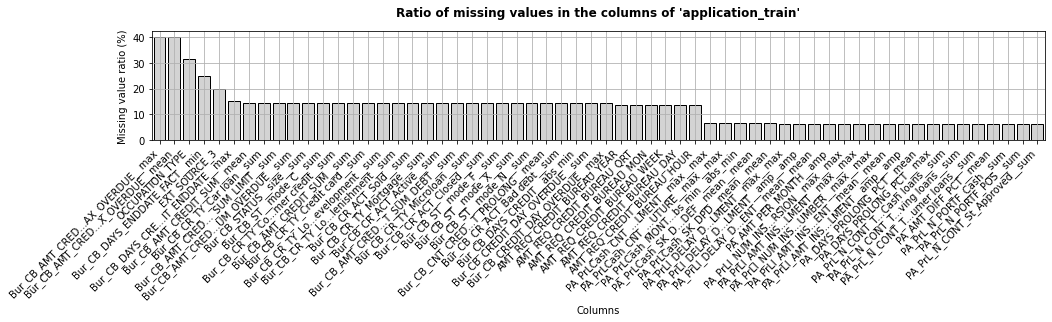

In [27]:
# 60 less filled features

ser = df_miss['Percent'][dict_df['app_train'].columns]\
                          .sort_values(ascending=False).iloc[:60]

plot_simple_barplot(x = ser.index,
                    y = ser.values,
                    x_lab='Columns', y_lab='Missing value ratio (%)',
                    title="Ratio of missing values in the columns of 'application_train'",
                    shorten_label=15, figsize=(16,2), color='lightgrey')

#### Exploring values of the remaining columns

In [28]:
# getting categorical and quantitative columns

cat_cols = dict_df['app_train'].select_dtypes(exclude=[np.number]).columns
quant_cols = dict_df['app_train'].select_dtypes(include=[np.number]).columns

bin_cols = dict_df['app_train'].columns[dict_df['app_train'].nunique()==2]
int_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['int']).columns \
                                                if c not in bin_cols]
f64_cols = \
    [c for c in dict_df['app_train'].select_dtypes(include=['float64']).columns \
                                                if c not in bin_cols]
f64_low_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()<100]
f64_high_nunique = \
    dict_df['app_train'][f64_cols].columns\
            [dict_df['app_train'][f64_cols].nunique()>=100]

low_nunique = list(f64_low_nunique) + int_cols + list(cat_cols) + list(bin_cols)

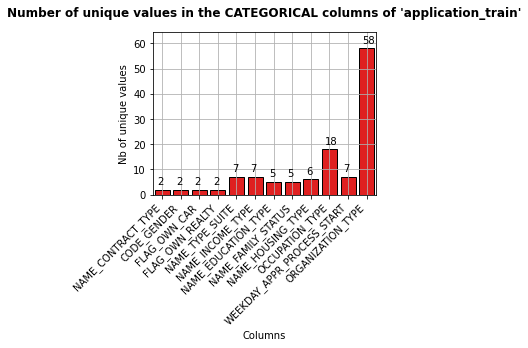

In [29]:
# number of unique values in each categorical column

if len(cat_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][cat_cols].columns, # [:100]
                        y =  dict_df['app_train'][cat_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the CATEGORICAL columns of 'application_train'",
                        shorten_label=15, figsize=(4,3), color='red',
                        annotate=True)

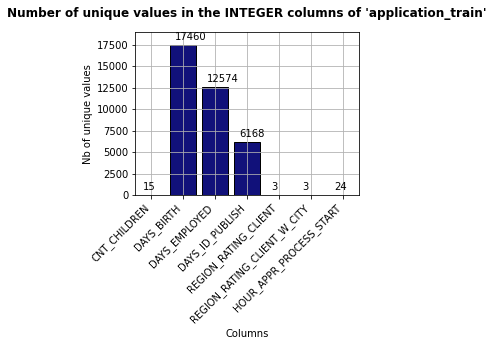

In [30]:
# number of unique values in each integer column

if len(int_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][int_cols].columns, # [:100]
                        y =  dict_df['app_train'][int_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the INTEGER columns of 'application_train'",
                        shorten_label=15, figsize=(4,3), color='darkblue',
                        annotate=True)

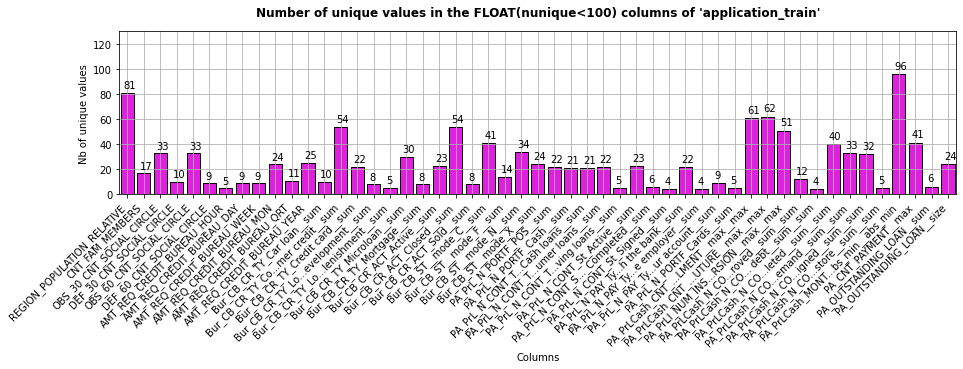

In [31]:
# number of unique values in each float column (with low nb of unique values)

if len(f64_low_nunique) > 0:
    plot_simple_barplot(x = dict_df['app_train'][f64_low_nunique].columns,
                        y =  dict_df['app_train'][f64_low_nunique].nunique(),
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the FLOAT(nunique<100) columns of 'application_train'",
                        shorten_label=15, figsize=(15,3), color='magenta',
                        annotate=True)

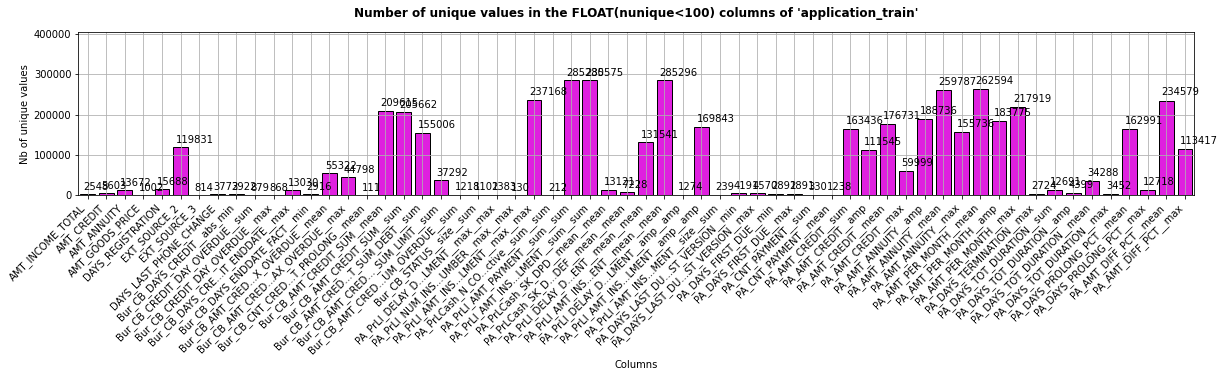

In [32]:
# number of unique values in each float column (with low nb of unique values)

if len(f64_high_nunique) > 0:
    plot_simple_barplot(x = dict_df['app_train'][f64_high_nunique].columns,
                        y =  dict_df['app_train'][f64_high_nunique].nunique(),
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the FLOAT(nunique<100) columns of 'application_train'",
                        shorten_label=15, figsize=(20,3), color='magenta',
                        annotate=True)

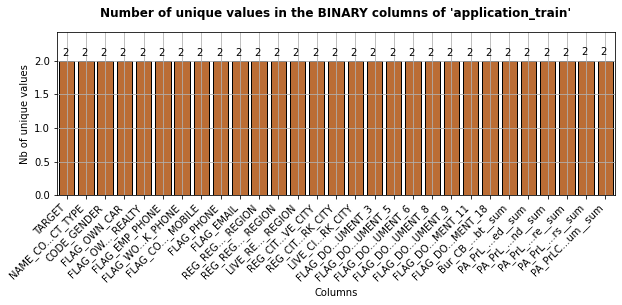

In [33]:
# number of unique values in each integer column

if len(bin_cols) > 0:
    plot_simple_barplot(x = dict_df['app_train'][bin_cols].columns, # [:100]
                        y =  dict_df['app_train'][bin_cols].nunique(), # .iloc[:100]
                        x_lab='Columns', y_lab='Nb of unique values',
                        title="Number of unique values in the BINARY columns of 'application_train'",
                        shorten_label=7, figsize=(10,3), color='chocolate',
                        annotate=True)

In [34]:
len(dict_df['app_train'].columns)

155

### 4.1 Univariate analysis

#### Number of uniques values and unique values

In [35]:
# show the number of unique values and the first unique values

dict_df['app_train'].agg([pd.Series.nunique,
                          lambda x: ['{}'.format(s) for s in x.unique()]]).T\
                          .sort_values('nunique')

,nunique,<lambda>
TARGET,2,"[1, 0]"
LIVE_REGION_NOT_WORK_REGION,2,"[0, 1]"
REG_CITY_NOT_LIVE_CITY,2,"[0, 1]"
REG_CITY_NOT_WORK_CITY,2,"[0, 1]"
FLAG_EMAIL,2,"[0, 1]"
FLAG_PHONE,2,"[1, 0]"
FLAG_CONT_MOBILE,2,"[1, 0]"
FLAG_WORK_PHONE,2,"[0, 1]"
FLAG_EMP_PHONE,2,"[1, 0]"
LIVE_CITY_NOT_WORK_CITY,2,"[0, 1]"


#### quantitative data

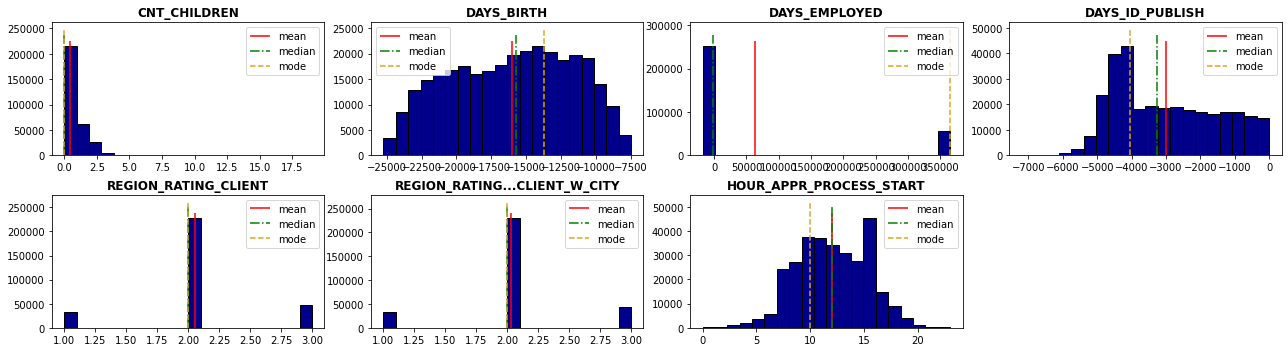

In [36]:
# integers
if len(int_cols) > 0:
    plot_histograms(dict_df['app_train'], int_cols, bins=20, figsize=(18,5),
                    color='darkblue', skip_outliers=False, thresh=None, n_cols=4,
                     tight_layout={'w_pad': 0.2,
                                   'h_pad':0.65})

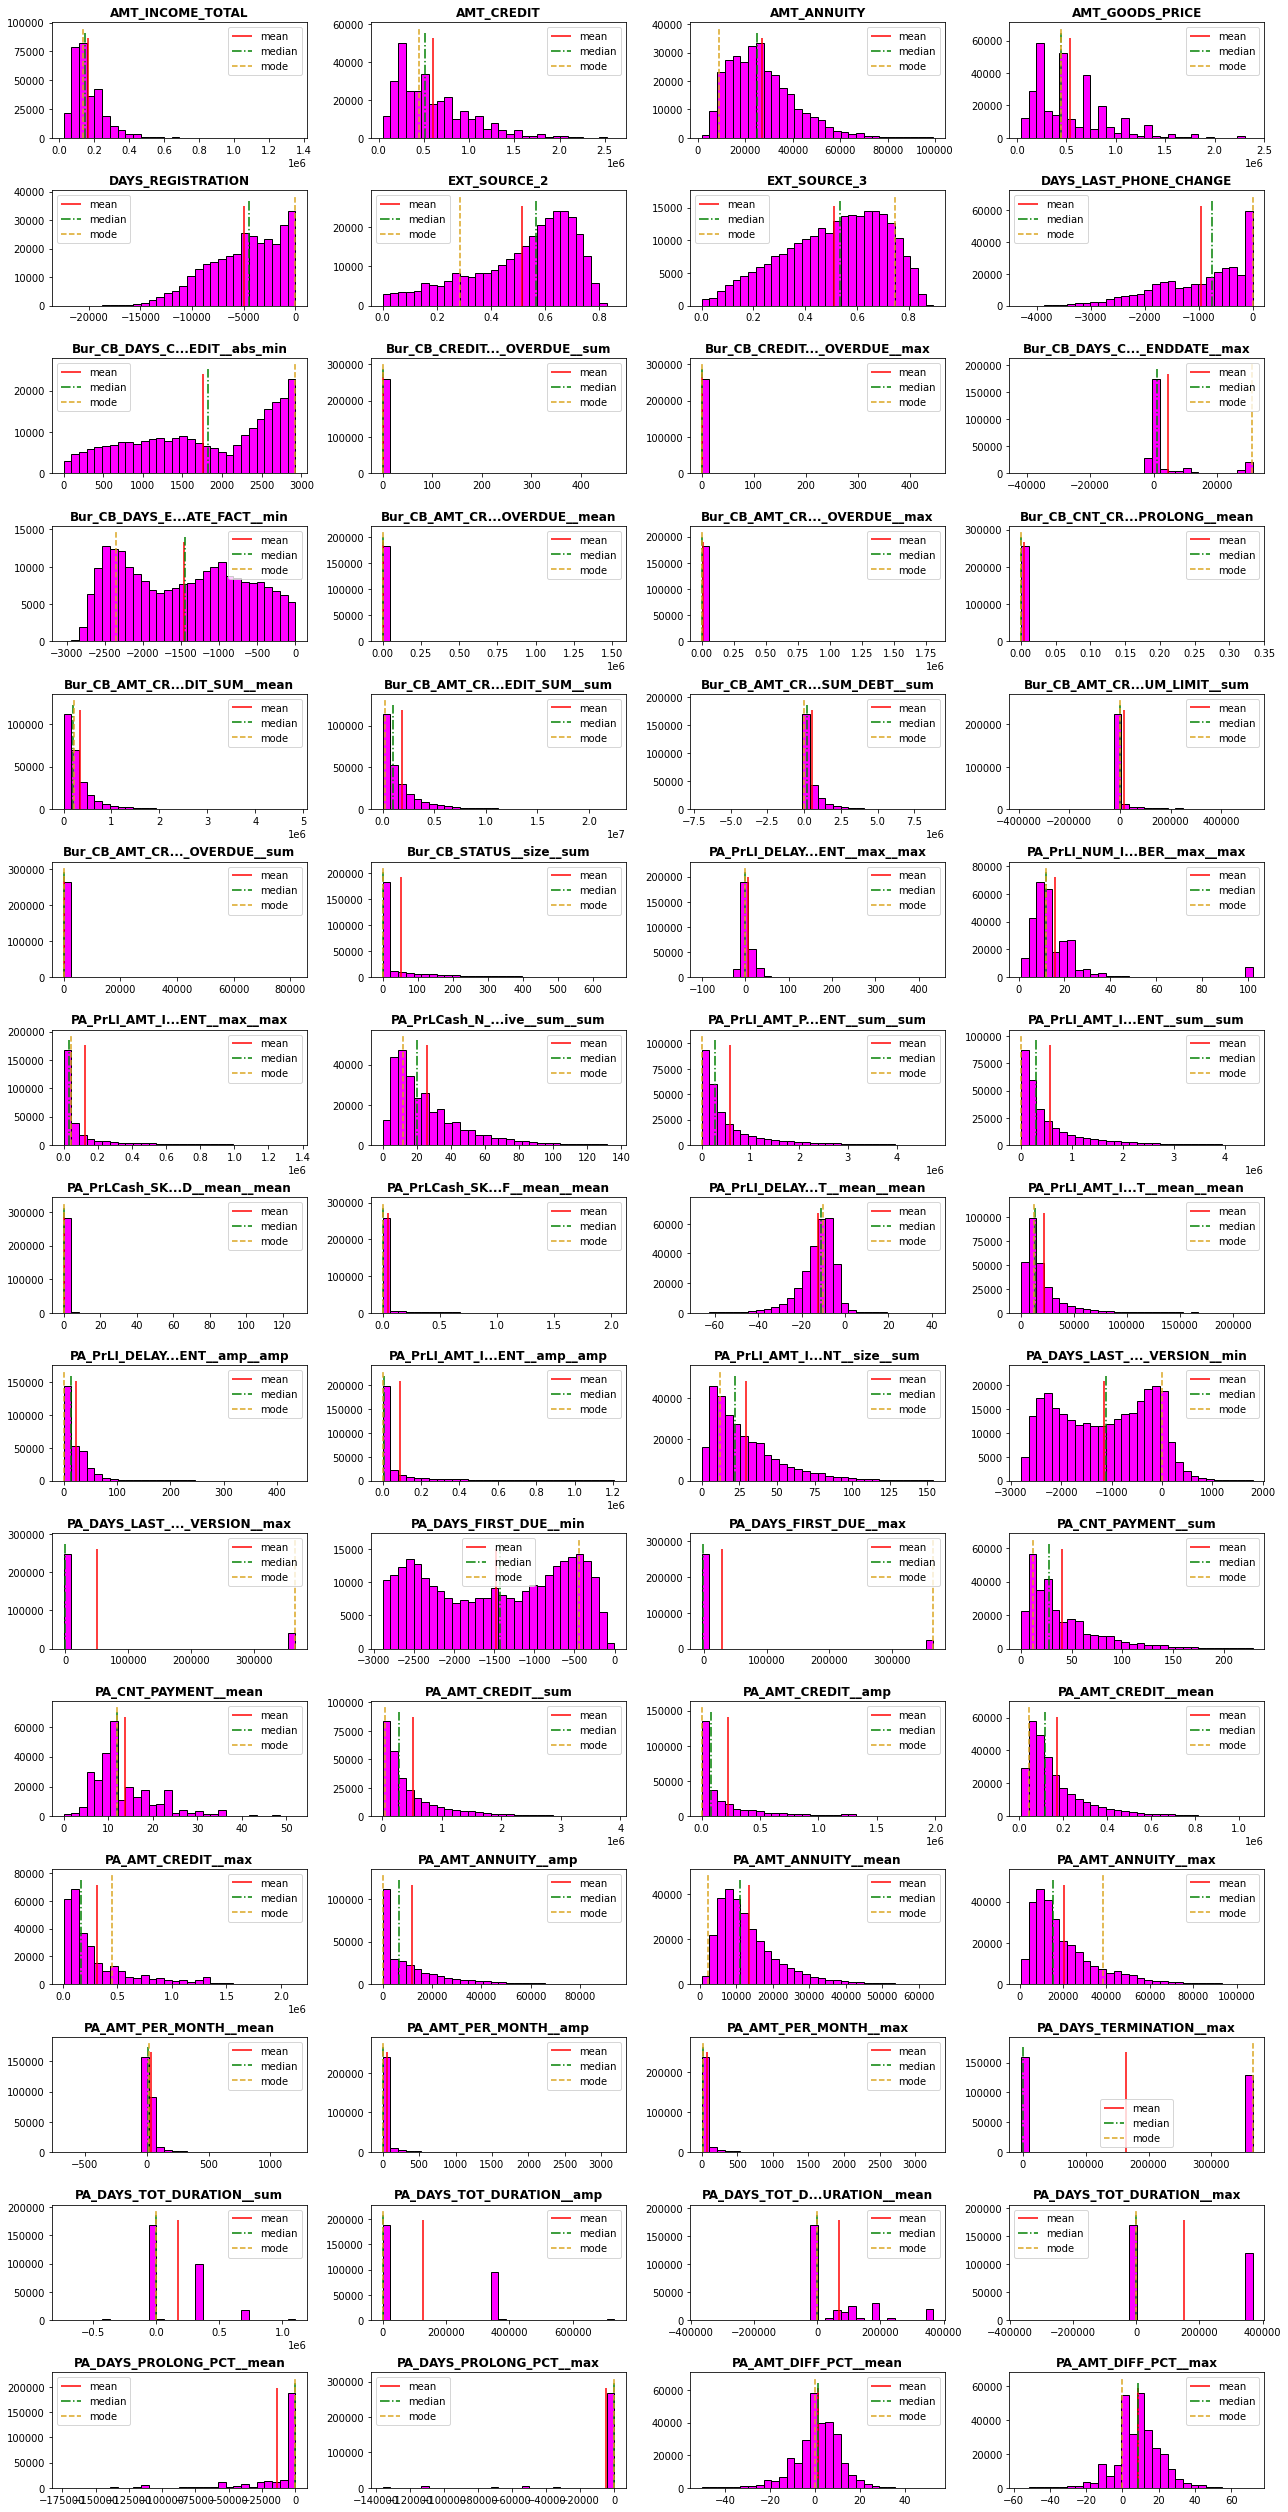

In [37]:
# floats (high nb of unique values) f64_low_nunique, f64_high_nunique

if len(f64_high_nunique) > 0:
    plot_histograms(dict_df['app_train'], f64_high_nunique, bins=30,
                    figsize=(18,35), color='magenta', skip_outliers=True,
                    thresh=5, n_cols=4, tight_layout={'w_pad': 0.2,
                                                      'h_pad':0.65})

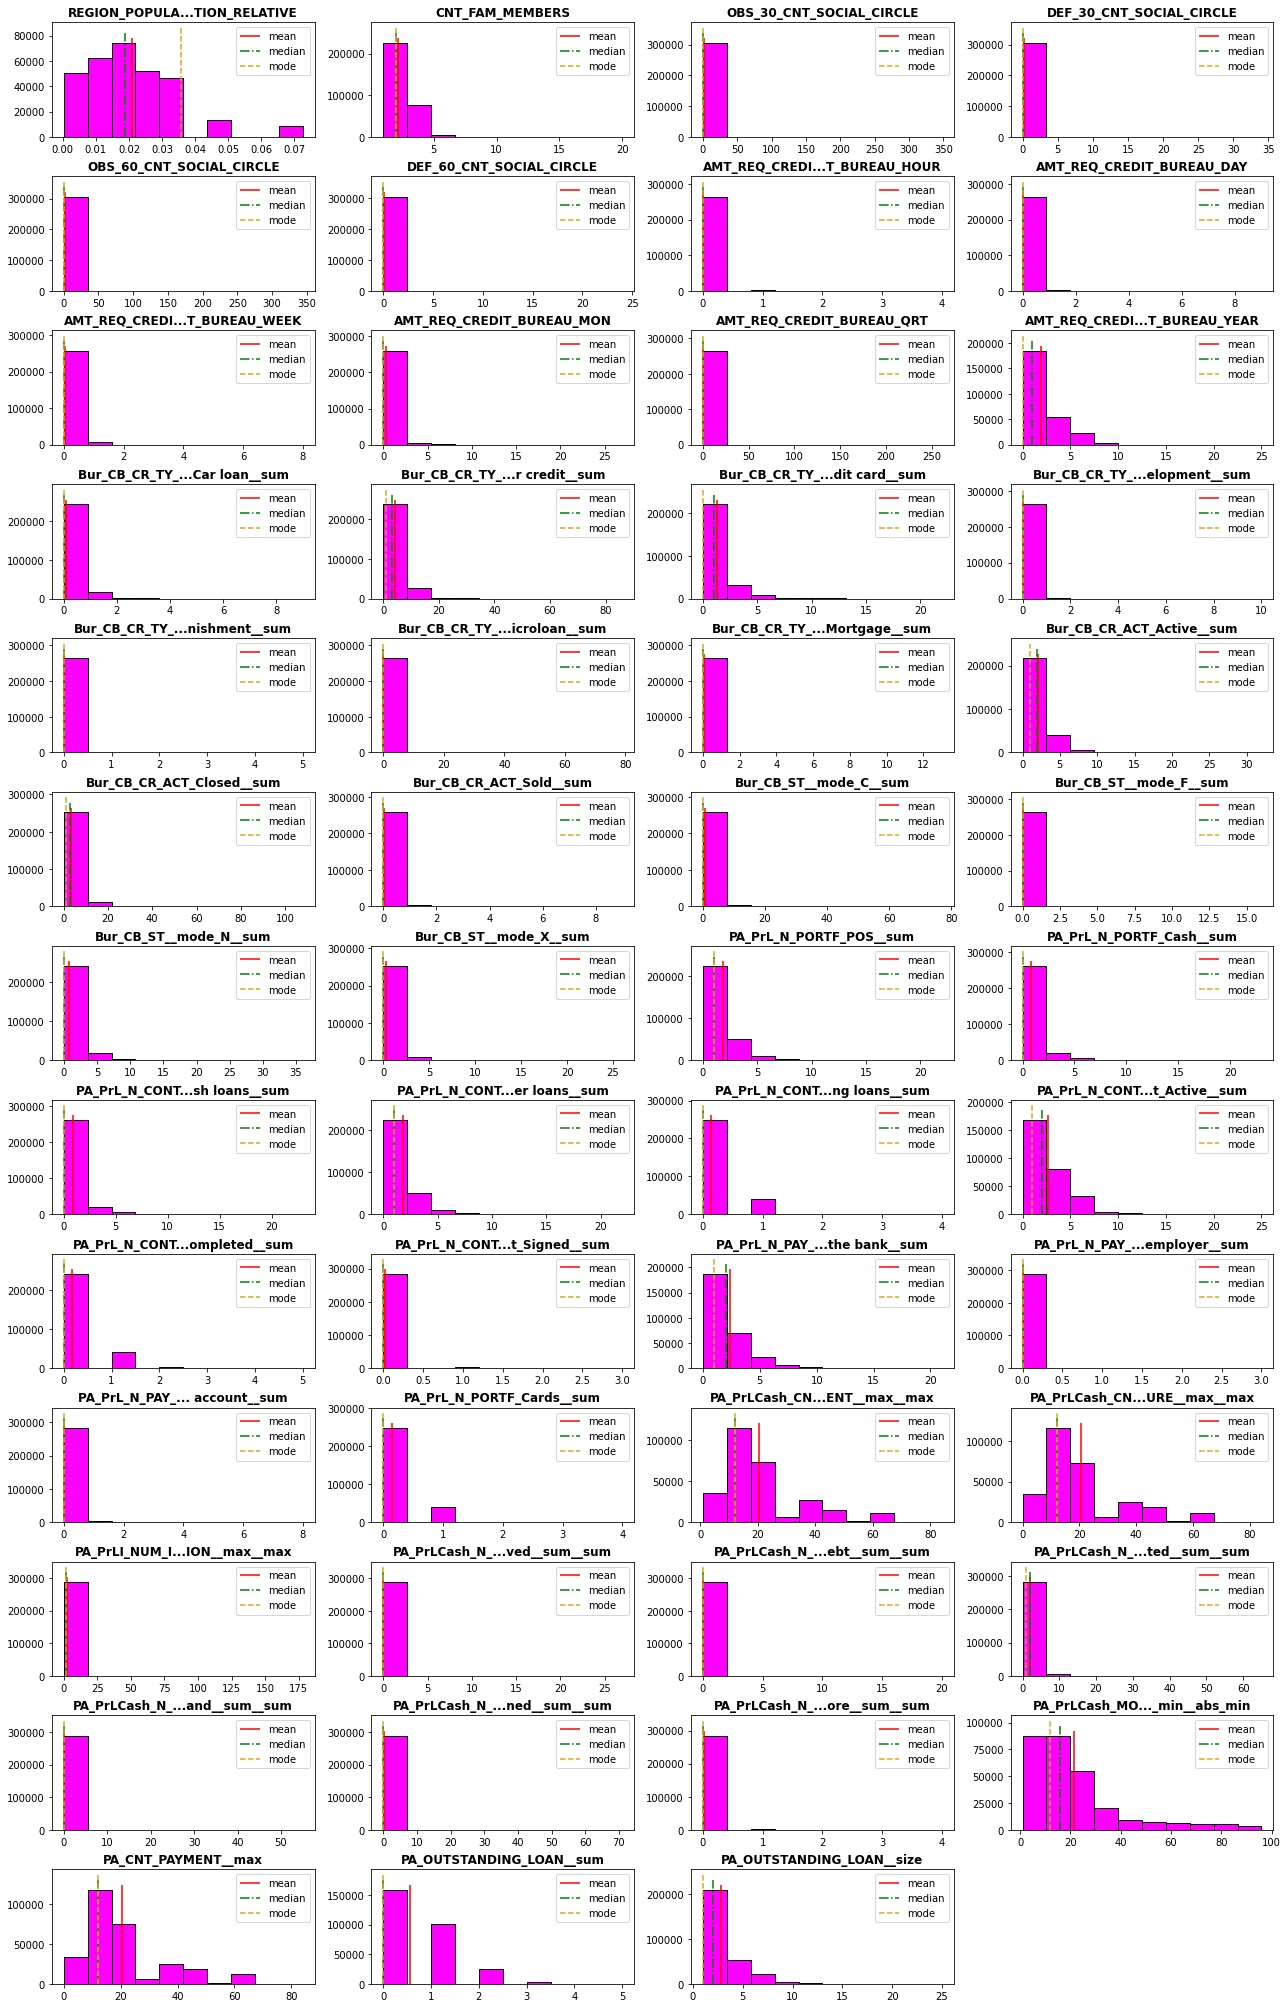

In [38]:
# floats (low nb of unique values) f64_low_nunique, f64_high_nunique

if len(f64_low_nunique) > 0:
    plot_histograms(dict_df['app_train'], f64_low_nunique, bins=10,
                        figsize=(18,28), color='magenta', skip_outliers=False,
                        thresh=5, n_cols=4, tight_layout={'w_pad': 0.2,
                                                          'h_pad':0.65})

#### categorical

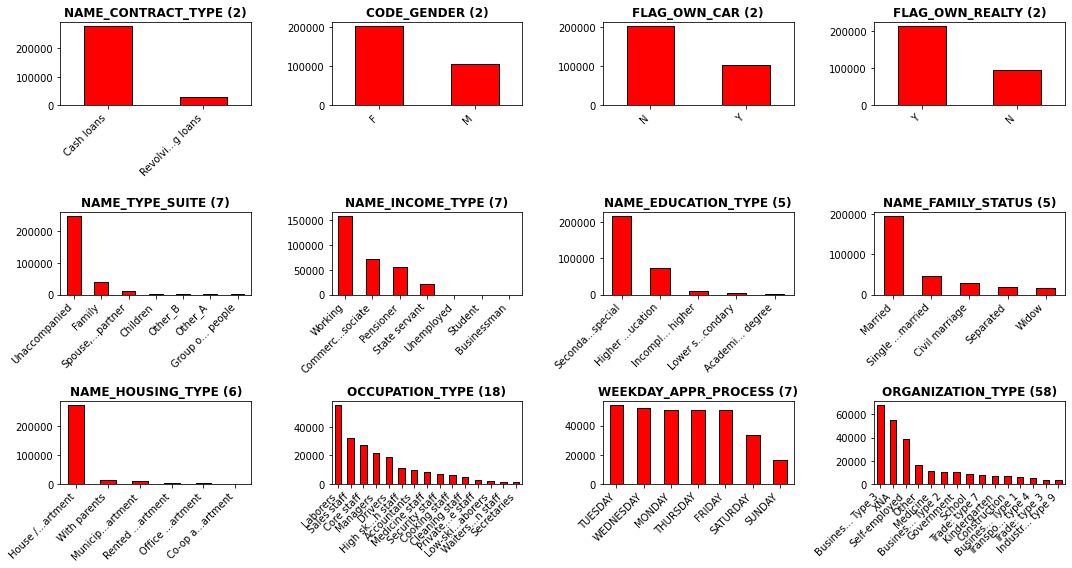

In [39]:
# explore the values of the categorical columns

plot_barplots(dict_df['app_train'], cat_cols, figsize=(15,8), n_cols=4,
              shorten_label=7, color='red')

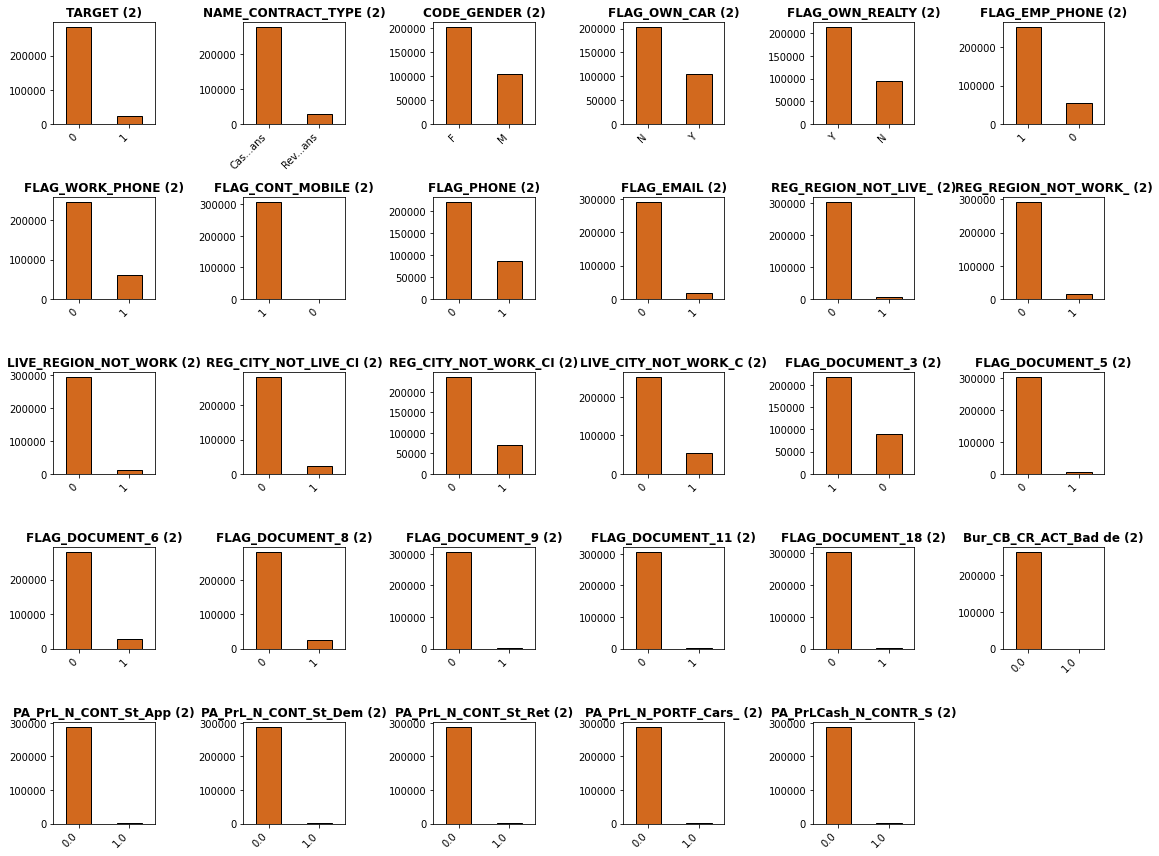

In [40]:
# explore the values of the binary columns

plot_barplots(dict_df['app_train'], bin_cols, figsize=(16,12), n_cols=6,
              shorten_label=3, color='chocolate')

Most of the quantitative features are normalized. Some are skewed or have 0 value overrepresentative.

Categorical and binary values are not balanced. May be won't contain much useful information...


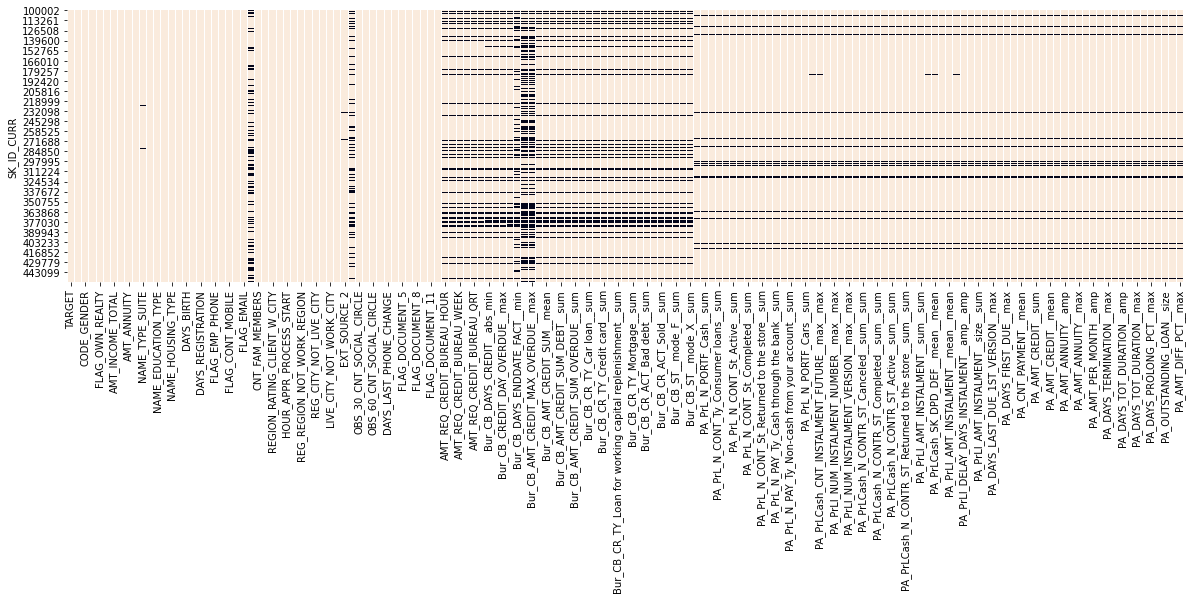

In [41]:
# global view of the missing values (black)

plt.figure(figsize=(20,5))
sns.heatmap(dict_df['app_train'].notna(), cbar=False)

In [42]:
# Have a overview of the number of missing values

df_miss = missing_data(dict_df['app_train'])

In [43]:
### create subdataframes

# Miscellaneous
cols = df_miss[(df_miss['Percent']<6)].index
df_1 = dict_df['app_train'][cols]
# display(df_1.select_dtypes().value_counts().to_frame())

# previous applications (Home Credit)
cols = df_miss[(df_miss['Percent']>6) & (df_miss['Percent']<13)].index
df_2 = dict_df['app_train'][cols]

# Previous requests to bureau
cols = df_miss[(df_miss['Percent']>13) & (df_miss['Percent']<14)].index
df_3 = dict_df['app_train'][cols]

# previous applications (Credit Bureau)
cols = df_miss[df_miss['Percent']>14].index
df_4 = dict_df['app_train'][cols]

### 4.2 Bivariate analysis

#### Target - features relationships

In [44]:
target_1_df = dict_df['app_train'][dict_df['app_train']['TARGET']==1]
target_0_df = dict_df['app_train'][dict_df['app_train']['TARGET']==0]

In [45]:
# cat_cols, quant_cols, bin_cols, int_cols, f64_cols, 
# f64_low_nunique, f64_high_nunique

In [46]:
cols =  f64_cols + int_cols
len(cols)

118

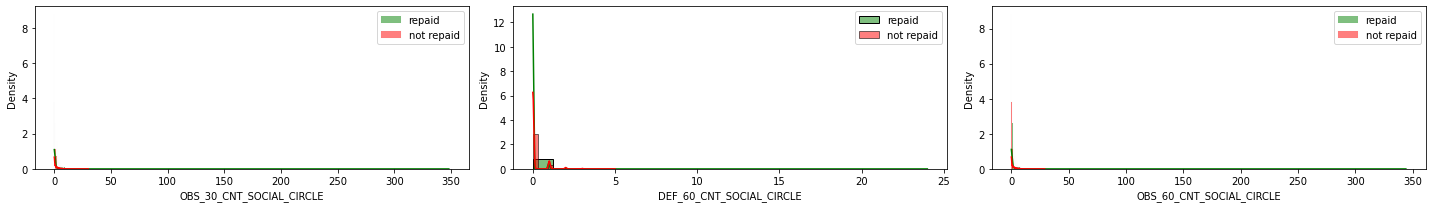

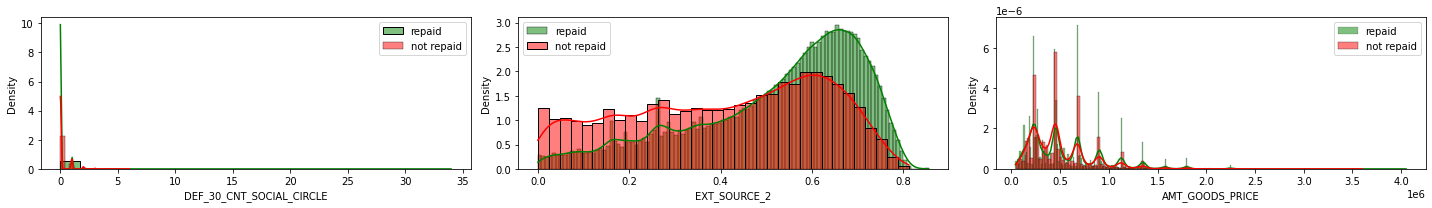

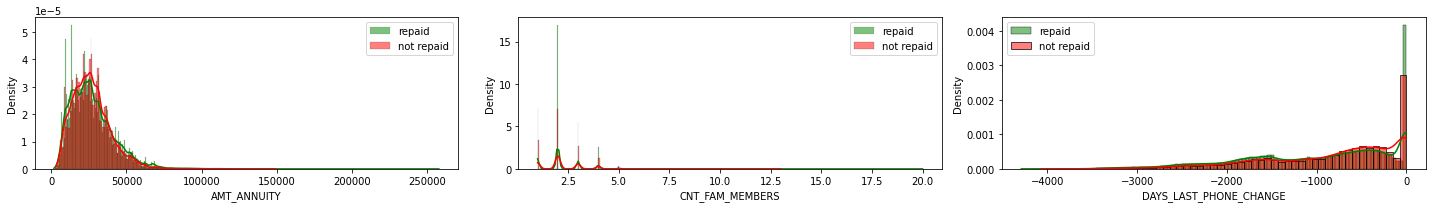

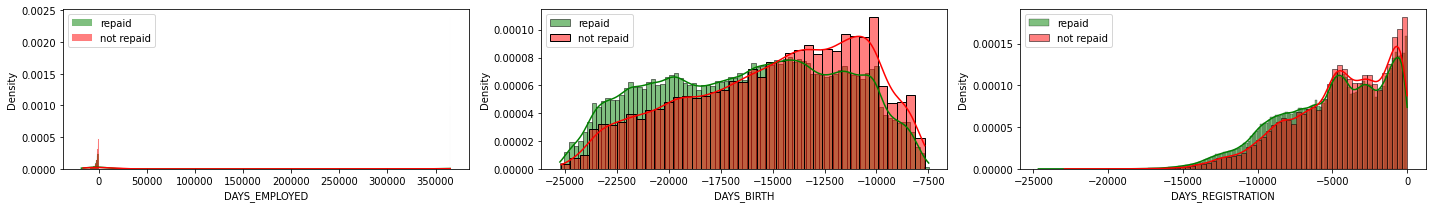

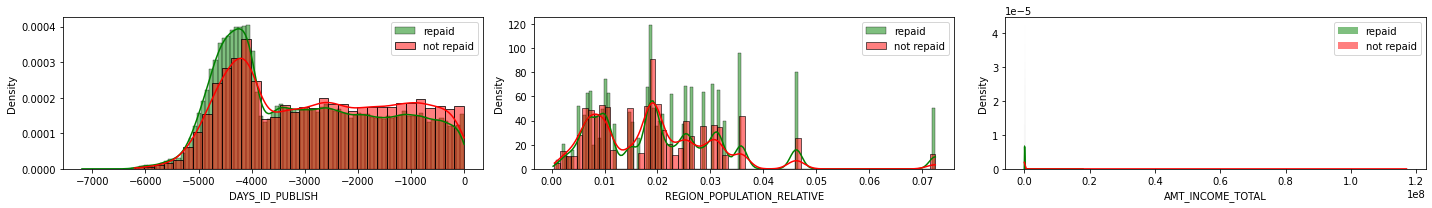

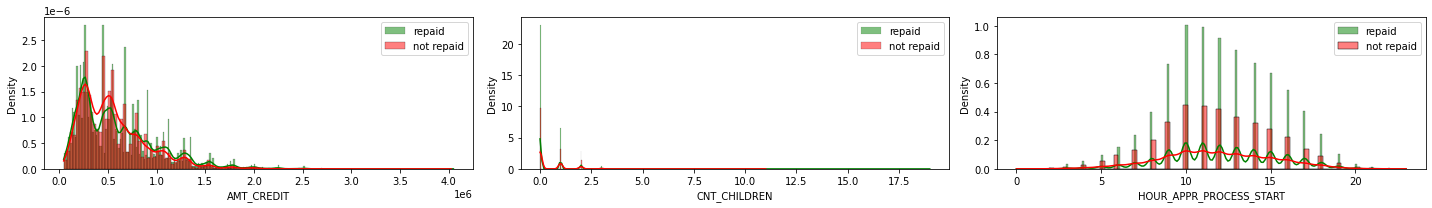

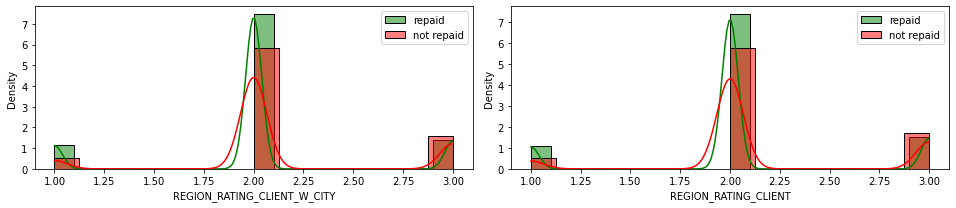

In [47]:
# All quantitative columns in Miscellaneous (df_1)

cols =  [col for col in df_1.columns if col in (f64_cols + int_cols)]
n_cols=3
n_tot = len(cols)
n_rows = (n_tot//n_cols)+((n_tot%n_cols)>0)*1
height = 2*n_rows


# loop on each row
for j, row in enumerate(range(n_rows), 0):

    fig = plt.figure(figsize=(20,3)) # height
    sub_cols = list(cols)[j*n_cols:(j+1)*n_cols]

    for i, col in enumerate(sub_cols, 1):

        ax = fig.add_subplot(1,n_cols,i)

        mask_na = dict_df['app_train'][col].notna()
        ser = dict_df['app_train'][col].loc[mask_na]
        mask_isfin = np.isfinite(ser)
        ser = ser.loc[mask_isfin]

        ind_0 = [i for i in ser.index if i in target_0_df.index]
        ind_1 = [i for i in ser.index if i in target_1_df.index] 

        sns.histplot(target_0_df.loc[ind_0, col],
                    label='repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='green', ax=ax)

        sns.histplot(target_1_df.loc[ind_1, col],
                    label='not repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='red', ax=ax)
        plt.legend()
        plt.tight_layout()
    plt.show()

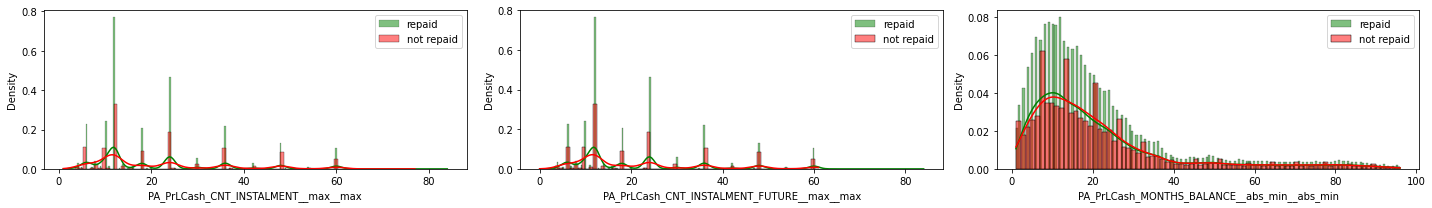

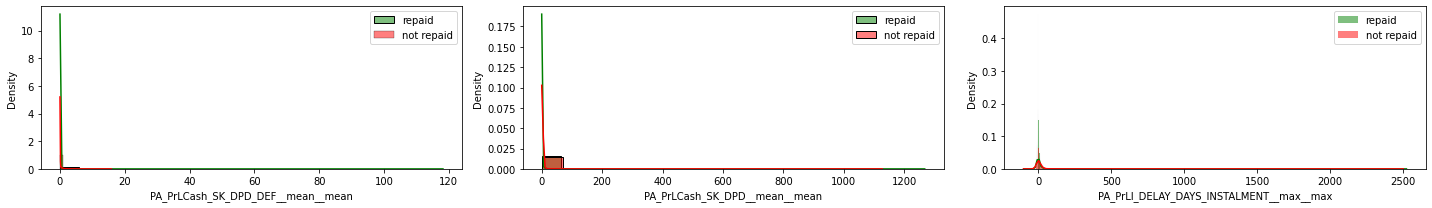

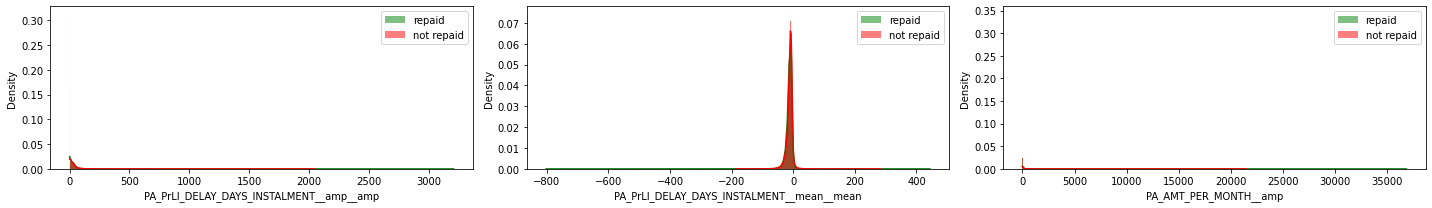

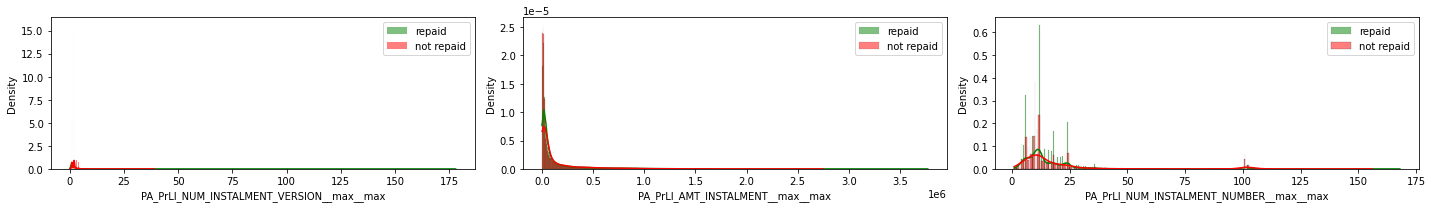

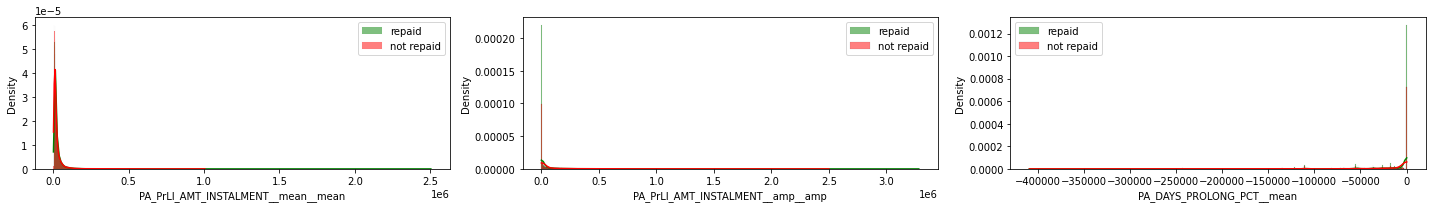

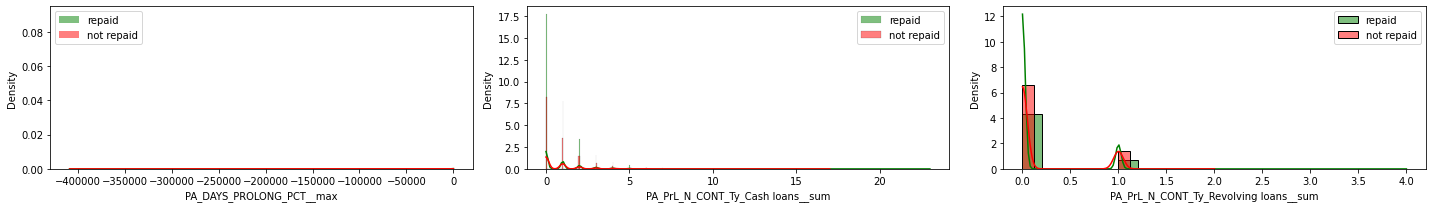

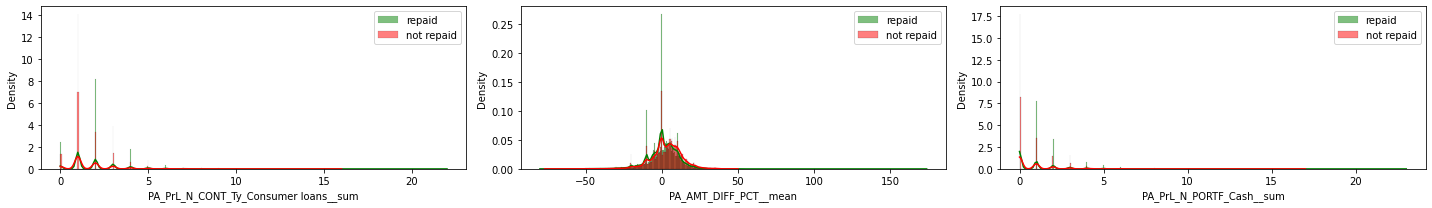

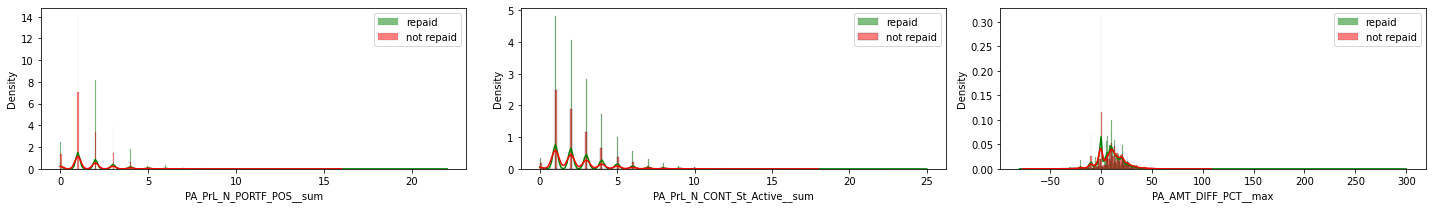

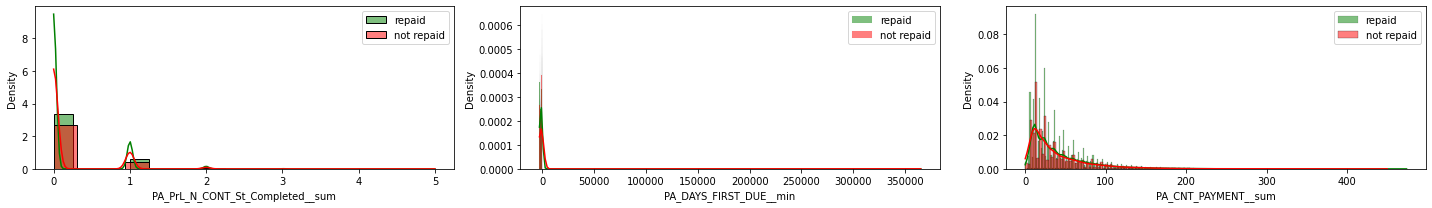

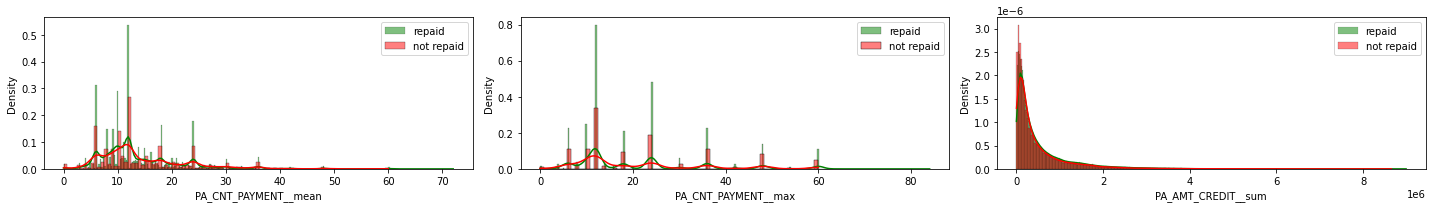

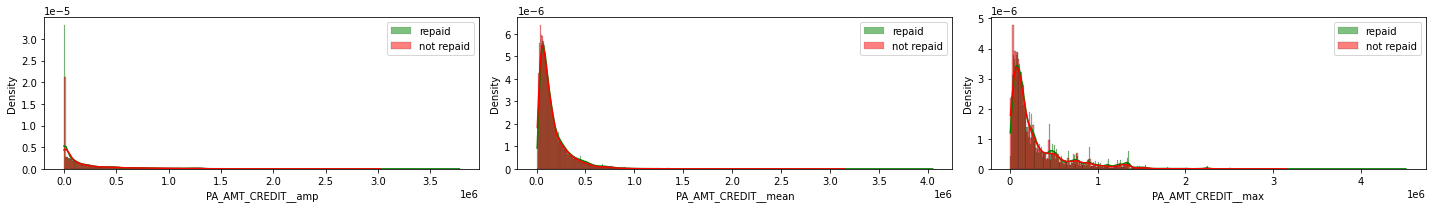

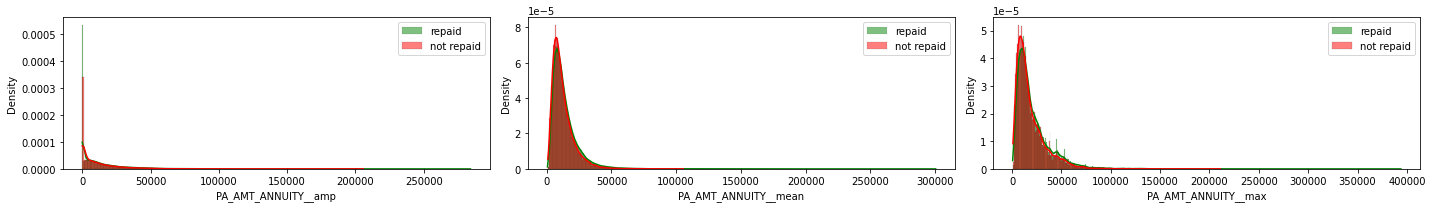

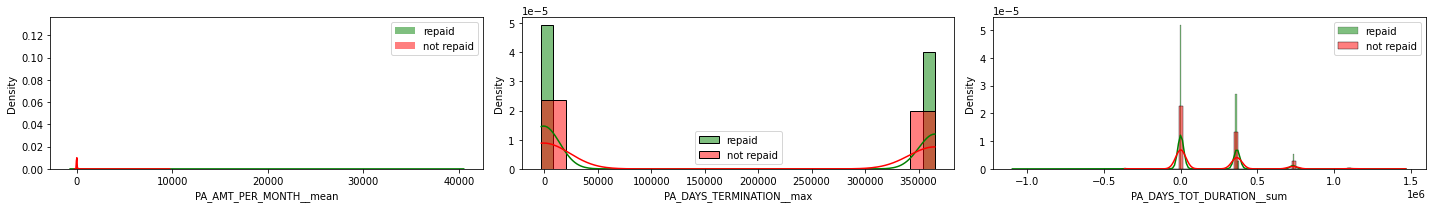

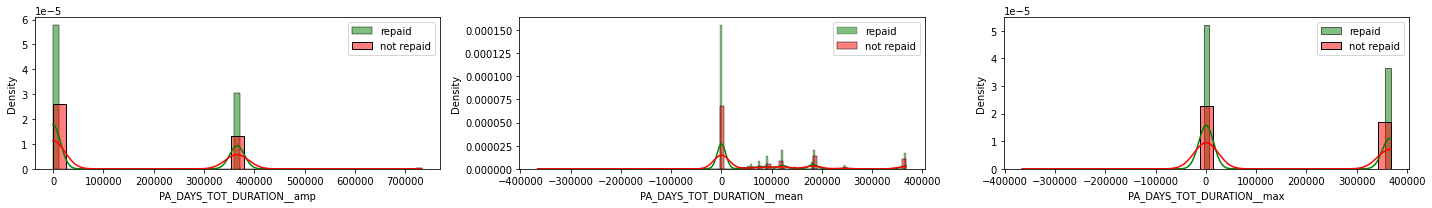

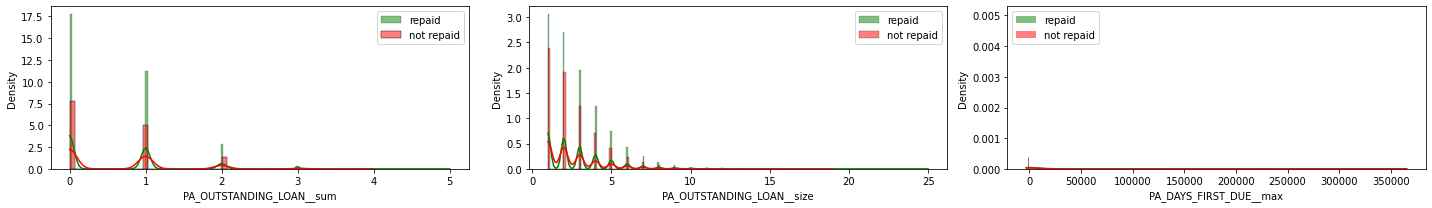

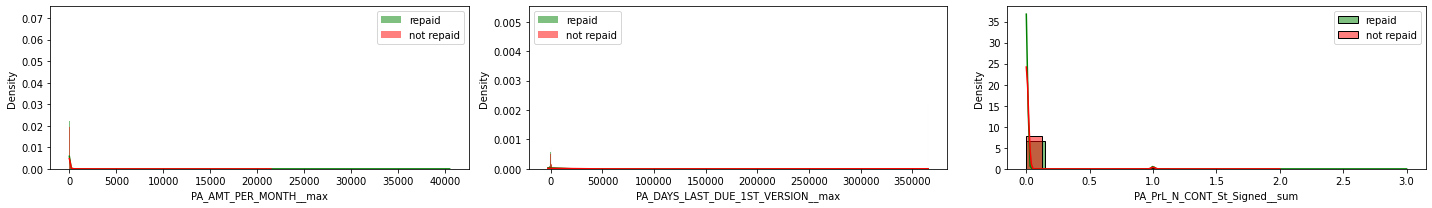

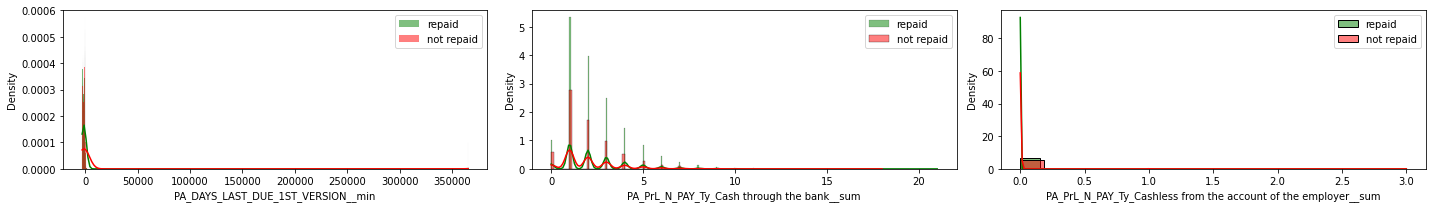

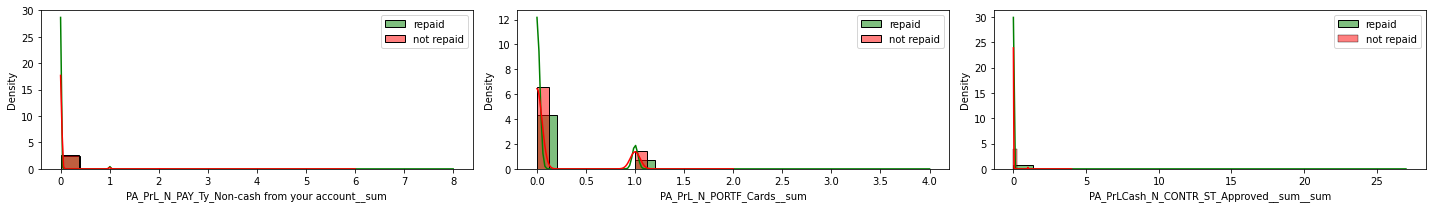

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


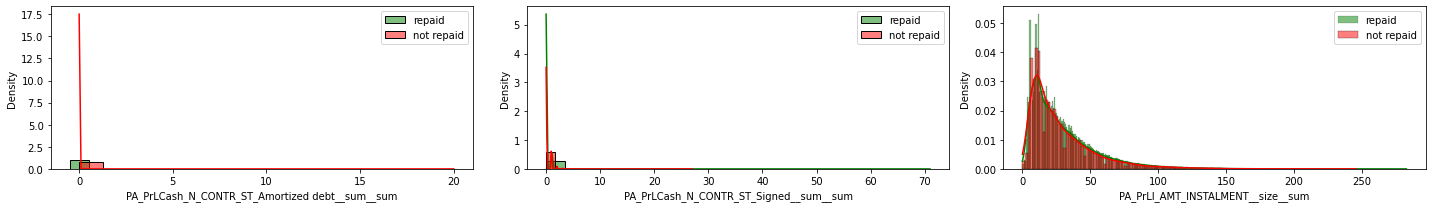

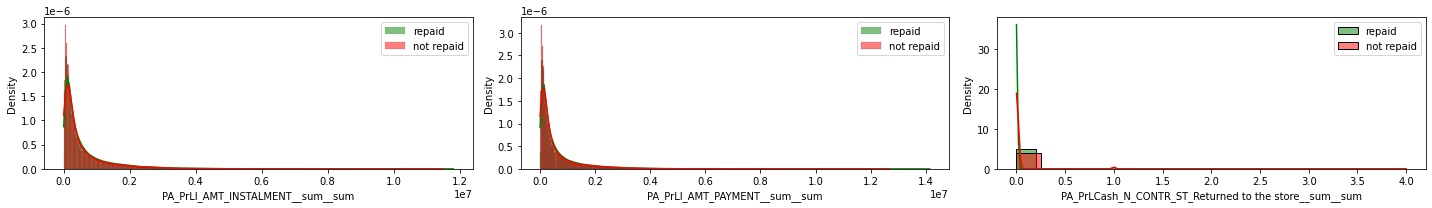

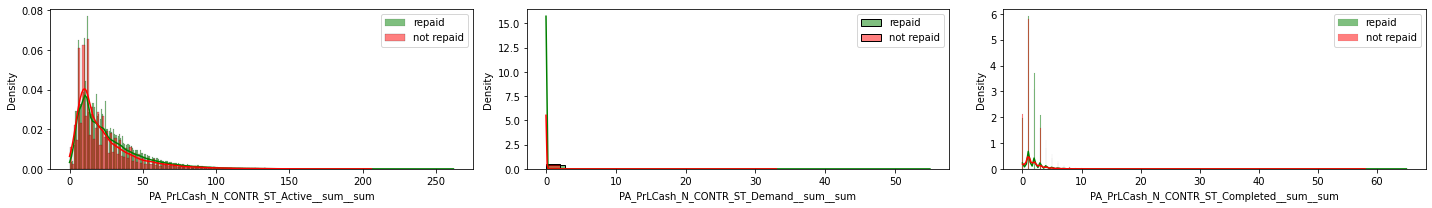

In [48]:
# All quantitative columns in previous applications (Home Credit) (df_2)

cols =  [col for col in df_2.columns if col in (f64_cols + int_cols)]
n_cols=3
n_tot = len(cols)
n_rows = (n_tot//n_cols)+((n_tot%n_cols)>0)*1
height = 2*n_rows


# loop on each row
for j, row in enumerate(range(n_rows), 0):

    fig = plt.figure(figsize=(20,3)) # height
    sub_cols = list(cols)[j*n_cols:(j+1)*n_cols]

    for i, col in enumerate(sub_cols, 1):

        ax = fig.add_subplot(1,n_cols,i)

        mask_na = dict_df['app_train'][col].notna()
        ser = dict_df['app_train'][col].loc[mask_na]
        mask_isfin = np.isfinite(ser)
        ser = ser.loc[mask_isfin]

        ind_0 = [i for i in ser.index if i in target_0_df.index]
        ind_1 = [i for i in ser.index if i in target_1_df.index] 

        sns.histplot(target_0_df.loc[ind_0, col],
                    label='repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='green', ax=ax)

        sns.histplot(target_1_df.loc[ind_1, col],
                    label='not repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='red', ax=ax)
        plt.legend()
        plt.tight_layout()
    plt.show()

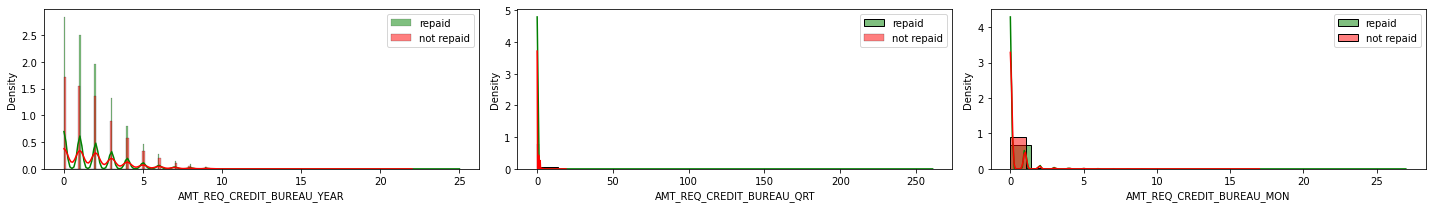

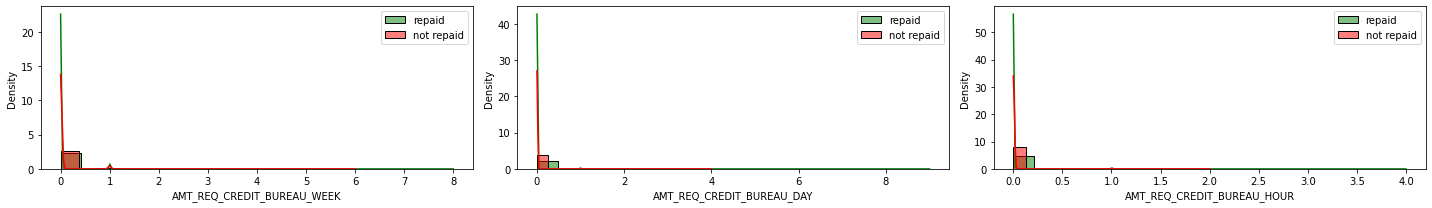

In [49]:
# All quantitative columns in Previous requests to bureau (Home Credit)  (df_3)  previous applications (Credit Bureau)

cols =  [col for col in df_3.columns if col in (f64_cols + int_cols)]
n_cols=3
n_tot = len(cols)
n_rows = (n_tot//n_cols)+((n_tot%n_cols)>0)*1
height = 2*n_rows


# loop on each row
for j, row in enumerate(range(n_rows), 0):

    fig = plt.figure(figsize=(20,3)) # height
    sub_cols = list(cols)[j*n_cols:(j+1)*n_cols]

    for i, col in enumerate(sub_cols, 1):

        ax = fig.add_subplot(1,n_cols,i)

        mask_na = dict_df['app_train'][col].notna()
        ser = dict_df['app_train'][col].loc[mask_na]
        mask_isfin = np.isfinite(ser)
        ser = ser.loc[mask_isfin]

        ind_0 = [i for i in ser.index if i in target_0_df.index]
        ind_1 = [i for i in ser.index if i in target_1_df.index] 

        sns.histplot(target_0_df.loc[ind_0, col],
                    label='repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='green', ax=ax)

        sns.histplot(target_1_df.loc[ind_1, col],
                    label='not repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='red', ax=ax)
        plt.legend()
        plt.tight_layout()
    plt.show()

In [1]:
# All quantitative columns in previous applications (Credit Bureau)  (df_4)  

cols =  [col for col in df_4.columns if col in (f64_cols + int_cols)]
n_cols=3
n_tot = len(cols)
n_rows = (n_tot//n_cols)+((n_tot%n_cols)>0)*1
height = 2*n_rows


# loop on each row
for j, row in enumerate(range(n_rows), 0):

    fig = plt.figure(figsize=(20,3)) # height
    sub_cols = list(cols)[j*n_cols:(j+1)*n_cols]

    for i, col in enumerate(sub_cols, 1):

        ax = fig.add_subplot(1,n_cols,i)

        mask_na = dict_df['app_train'][col].notna()
        ser = dict_df['app_train'][col].loc[mask_na]
        mask_isfin = np.isfinite(ser)
        ser = ser.loc[mask_isfin]

        ind_0 = [i for i in ser.index if i in target_0_df.index]
        ind_1 = [i for i in ser.index if i in target_1_df.index] 

        sns.histplot(target_0_df.loc[ind_0, col],
                    label='repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='green', ax=ax)

        sns.histplot(target_1_df.loc[ind_1, col],
                    label='not repaid', kde=True,
                    stat='density',
                    alpha=0.5, color='red', ax=ax)
        plt.legend()
        plt.tight_layout()
    plt.show()

NameError: ignored